# Spatial Regression

_Everything is related to everything else. But near things are more related than distant things_ - Waldo Tobler

Concepts
- Earnings Surprises
- Spatial Dependence


In [1]:
from pandas import DataFrame, Series
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import io
import zipfile
from libpysal.weights import W
from esda.moran import Moran
import spreg
import networkx as nx
import statsmodels.formula.api as smf
import warnings
import requests
from finds.database import SQL, RedisDB
from finds.structured import BusDay, CRSP, PSTAT
from finds.readers import Alfred
from finds.recipes import remove_outliers
from finds.utils import Store
from secret import credentials, paths, CRSP_DATE
#pd.set_option('display.max_rows', 50)
VERBOSE = 0
#%matplotlib qt

In [2]:
# open connections
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
rdb = RedisDB(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
pstat = PSTAT(sql, bd, verbose=VERBOSE)
store = Store(paths['scratch'])

In [3]:
LAST_DATE = CRSP_DATE
scheme = 'tnic3'
# fetch NBER recession dates
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE)
vspans = alf.date_spans('USREC')  # to indicate recession periods in the plots

## Earnings surprise

An earnings surprise, or unexpected earnings, is the difference between the reported earnings and expected earnings.

In [ ]:
# require and get actual quarterly earnings, reindex by (permno, rebaldate)
df = pstat.get_linked(dataset='quarterly',
                      fields=['prccq', 'cshoq', 'ibq'],
                      date_field='datadate',
                      where=f"datadate <= {LAST_DATE}")
store['fund'] = df

In [ ]:
df = store['fund']

In [ ]:
fund = df.dropna(subset=['ibq'])\
         .sort_values(['permno', 'datadate', 'cshoq'])\
         .drop_duplicates(['permno', 'datadate'])\
         .reset_index()
fund['rebaldate'] = bd.endmo(fund['datadate'])

# calculate sue with lag(4) difference in compustat quarterly and price
lag = fund.shift(4, fill_value=0)
keep = ((lag['permno'] == fund['permno']) &
        (fund['prccq'] > 5)).values
fund.loc[keep, 'sue'] = ((fund.loc[keep, 'ibq'] - lag.loc[keep, 'ibq']) /
                         abs(fund.loc[keep, 'prccq'] * fund.loc[keep, 'cshoq']))
print('with pstat earnings', np.sum(~fund['sue'].isna()))

In [ ]:
# Retrieve TNIC schemes from Hoberg and Phillips website
root = 'https://hobergphillips.tuck.dartmouth.edu/idata/'
source = root + scheme + '_data.zip'
if source.startswith('http'):
    response = requests.get(source)
    source = io.BytesIO(response.content)
with zipfile.ZipFile(source).open(scheme + "_data.txt") as f:
    tnic_df = pd.read_csv(f, sep='\s+')
store['spatial'] = (fund, tnic_df)
tnic_df['year'].value_counts().sort_index().to_frame()


In [4]:
fund, tnic_df = store['spatial']

In [5]:
sue = fund.loc[~fund['sue'].isna(), ['permno', 'rebaldate', 'sue']]\
          .reset_index(drop=True)
sue['rebaldate'] //= 100

In [6]:
lookup = pstat.build_lookup(source='lpermno', target='gvkey', fillna=0)

## Spatial dependence models


### Moran's I

$$E(I) = \dfrac{-1}{N-1}$$

summary results compare to null of zero so is more conservative
(difference compared to true expectations is more positive than calculated)

https://en.wikipedia.org/wiki/Moran%27s_I

### Spatial lag model

https://lost-stats.github.io/Geo-Spatial/spatial_lag_model.html

https://pysal.org/spreg/generated/spreg.ML_Lag.html

spatial lag model $Y_i = \beta X_i + \rho WY_j + \epsilon_i$

where 

- $Y_j$ is the set of $Y$ values from observations other than $i$, 
- $W$ is a matrix of spatial weights, which are higher for $j$s 
  that are spatially closer to $i$.
  

In [7]:
# Compute quarterly spatial regressions
out = dict(moran={}, rho={}, beta={})
years = range(1988, 2022)
for year in tqdm(years):
    tnic = tnic_df[tnic_df.year == year].dropna()  # extract the year's tnic links

    # populate graph from tnic edges, with gvkey as nodes
    graph = nx.Graph()
    graph.add_edges_from(tnic[['gvkey1', 'gvkey2']].values)
    graph.remove_edges_from(nx.selfloop_edges(graph))   # not necessary

    for qtr in [12, 103, 106, 109]:   # loop over next four quarters of sue
        rebaldate = year*100 + qtr

        # extract sue's with in this fiscal quarter
        y = sue[sue['rebaldate'] == rebaldate].set_index('permno')[['sue']]

        # lookup gvkeys
        y['gvkey'] = lookup(y.index, date=bd.endmo(rebaldate))

        # merge in stock returns in the quarter
        y = y.join(crsp.get_ret(bd.begmo(rebaldate, months=-2),
                                bd.endmo(rebaldate)),
                   how='left')\
             .set_index('gvkey')
            
        # require available and not outlier
        y = remove_outliers(y[~y.index.duplicated() & (y.index > 0)]).dropna()

        # extract subgraph, its nodes and their neighbors
        G = graph.subgraph(y.index)
        G = G.subgraph(max(nx.connected_components(G), key=len)) 
        neighbors = {node: list(G.neighbors(node)) for node in G.nodes()}
        w = W(neighbors)
        y = y.loc[sorted(neighbors.keys())]

        # compute Moran's I and spatial lag model of sue on past stock returns
        mi = Moran(y['sue'].values,  w)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            spatial = spreg.ML_Lag(y=y['sue'].values, x=y[['ret']].values, w=w,
                                   name_x=['ret'], name_y='sue', name_w=scheme,
                                   name_ds=str(rebaldate))
        out['moran'][rebaldate] = mi.I
        out['rho'][rebaldate] = float(spatial.rho)
        out['beta'][rebaldate] = float(spatial.betas[1])

100%|██████████| 34/34 [10:56<00:00, 19.30s/it]


In [8]:
# Show latest quarter's results
print(spatial.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :      202209
Weights matrix      :       tnic3
Dependent Variable  :         sue                Number of Observations:        2464
Mean dependent var  :     -0.0009                Number of Variables   :           3
S.D. dependent var  :      0.0337                Degrees of Freedom    :        2461
Pseudo R-squared    :      0.0786
Spatial Pseudo R-squared:  0.0037
Sigma-square ML     :       0.001                Log likelihood        :    4937.681
S.E of regression   :       0.032                Akaike info criterion :   -9869.362
                                                 Schwarz criterion     :   -9851.933

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

In [9]:
# Show spatial regression results
ols = spreg.OLS(y=y['sue'].values, x=y[['ret']].values, w=w,
                robust='white', spat_diag=True, moran=True,
                name_x=['ret'], name_y='sue', name_w=scheme,
                name_ds=str(rebaldate))
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :      202209
Weights matrix      :       tnic3
Dependent Variable  :         sue                Number of Observations:        2464
Mean dependent var  :     -0.0009                Number of Variables   :           2
S.D. dependent var  :      0.0337                Degrees of Freedom    :        2462
R-squared           :      0.0044
Adjusted R-squared  :      0.0040
Sum squared residual:       2.786                F-statistic           :     10.9488
Sigma-square        :       0.001                Prob(F-statistic)     :   0.0009502
S.E. of regression  :       0.034                Log likelihood        :    4862.690
Sigma-square ML     :       0.001                Akaike info criterion :   -9721.379
S.E of regression ML:      0.0336                Schwarz criterion     :   -9709.760

White Standard Errors
-------------------------------------------------------

In [10]:
# Show Moran's I
print(f"Quarter: {rebaldate}") 
DataFrame({"Moran's I": mi.I, "Expected": mi.EI, "p_norm": mi.p_norm},
          index=["under assumption of normality"])

Quarter: 202209


,Moran's I,Expected,p_norm
under assumption of normality,0.136383,-0.000406,2.128943e-53


In [13]:
# Show ordinary regression results
results = DataFrame(out)
results.index = bd.to_datetime(bd.endmo(results.index))
summary = dict()
for col in results.columns:
    model = smf.ols(f'{col} ~ 1', data=results).fit()
    robust = smf.ols(f'{col} ~ 1', data=results)\
                .fit(cov_type='HAC', cov_kwds={'maxlags': 6})
    summary[col] = dict(mean=float(model.params.iloc[0]),
                        stderr=float(model.bse.iloc[0]),
                        t=float(model.tvalues.iloc[0]),
                        nw_stderr=float(robust.bse.iloc[0]),
                        nw_t=float(robust.tvalues.iloc[0]))
print("Tests of statistical significance")
DataFrame(summary)

Tests of statistical significance


,moran,rho,beta
mean,0.053145,0.224963,0.012003
stderr,0.002668,0.009765,0.000720
t,19.919201,23.036839,16.672970
nw_stderr,0.004736,0.018049,0.000979
nw_t,11.220779,12.463735,12.265549


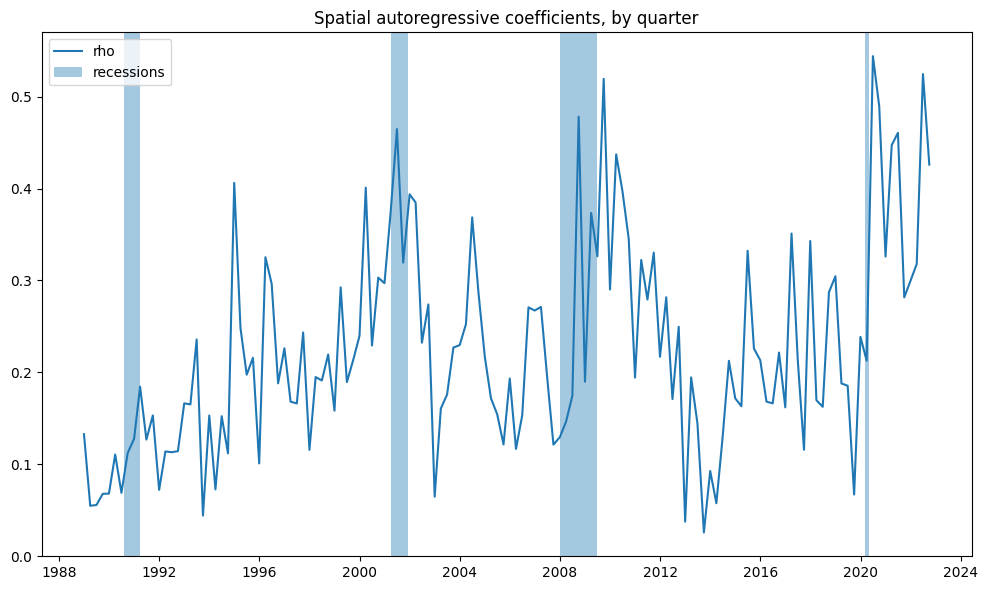

In [12]:
# Visualize autoregressive coefficients by quarter
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results['rho'])
ax.set_title("Spatial autoregressive coefficients, by quarter")
for a,b in vspans:
    if a >= min(results.index):
        ax.axvspan(a, min(b, max(results.index)), alpha=0.4)
plt.legend(['rho', 'recessions'])
plt.tight_layout()
plt.show()